In [27]:
import numpy as np
import a4_utils as a4u
import UZ_utils
import matplotlib.pyplot as plt
import cv2
import math
import os
import random

# 1 a

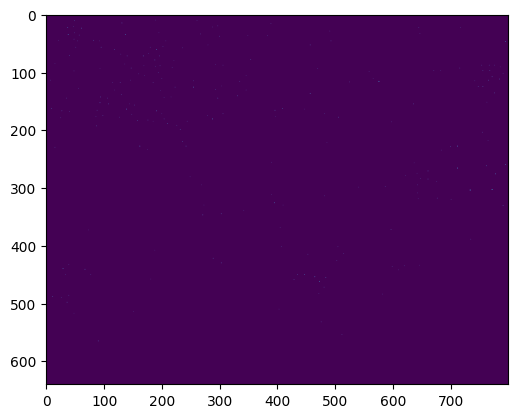

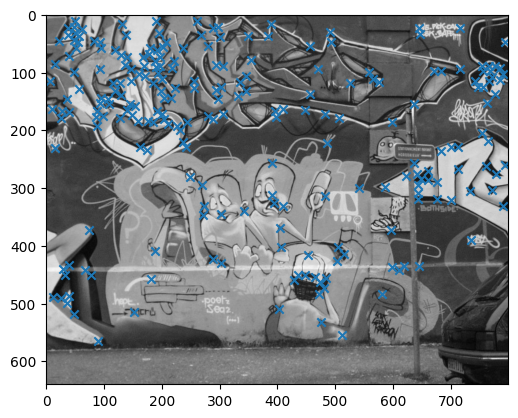

In [28]:
def gaussdx(sigma: float):
    side_width = int(math.ceil(3*sigma))
    kernel_size = int(2 * side_width +1)
    kernel_x_values = np.array(range(-side_width, side_width+1))
    coef = -1 / ((sigma ** 3) * math.sqrt(2*math.pi))
    kernel =  coef * kernel_x_values * np.exp( -(kernel_x_values ** 2) / (2* (sigma**2)) )
    
    kernel_abs = np.abs(kernel)
    kernel /= np.sum(kernel_abs)
    return kernel, kernel_x_values

def gauss(sigma: float):
    side_width = int(math.ceil(3*sigma))
    kernel_size = int(2 * side_width +1)
    kernel_x_values = np.array(range(-side_width, side_width+1))
    coef = 1 / (sigma * math.sqrt(2*math.pi))
    kernel =  coef * np.exp( -(kernel_x_values ** 2) / (2* (sigma**2)) )
    kernel /= np.sum(kernel)
    return kernel, kernel_x_values

def gauss_kern_horizontal_faux2D(sigma: float):
    ker = gauss(sigma)[0].reshape(1, -1)
    return ker

def gaussdx_kern_horizontal_faux2D(sigma: float):
    ker = gaussdx(sigma)[0].reshape(1, -1)
    return ker

def image_partial_derivatives(image, sigma: float):
    x_gauss = gauss_kern_horizontal_faux2D(sigma)
    y_gauss = x_gauss.T
    x_gauss_der = gaussdx_kern_horizontal_faux2D(sigma)
    y_gauss_der = x_gauss_der.T

    x_partial = UZ_utils.convolve(image, y_gauss, x_gauss_der)
    y_partial = UZ_utils.convolve(image, x_gauss, y_gauss_der)
    return x_partial, y_partial

def image_second_partial_ders(image, sigma: float):
    x_partial, y_partial = image_partial_derivatives(image, sigma)
    
    x_second_partial, xy_second_partial = image_partial_derivatives(x_partial, sigma)
    _, y_second_partial = image_partial_derivatives(y_partial, sigma)

    return x_second_partial, xy_second_partial, y_second_partial

def hessian_treshold(image, sigma, t, neigh_one_side_size):
    """
    dx_kernel = -np.ones((1, 2))
    dx_kernel[0,0] = 1
    print("dx_kernel")
    print(dx_kernel)

    dy_kernel = -np.ones((2, 1))
    dy_kernel[0,0] = 1
    print("dy_kernel")
    print(dy_kernel)


    gauss_1dim = a4u.gauss(sigma)
    gauss_2dim = gauss_1dim.T * gauss_1dim
    print("gauss_2dim")
    print(gauss_2dim)
    print("gauss_2dim.sum()")
    print(gauss_2dim.sum())
    UZ_utils.imshow(gauss_2dim)


    graf_gauss = a4u.convolve(image, gauss_2dim)

    graf_gauss = graf_gauss / graf_gauss.max()

    graf_dx = a4u.convolve(graf_gauss, dx_kernel)
    graf_dy = a4u.convolve(graf_gauss, dy_kernel)

    graf_xx = a4u.convolve(graf_dx, dx_kernel)
    graf_xy = a4u.convolve(graf_dx, dy_kernel)
    graf_yy = a4u.convolve(graf_dy, dy_kernel)
    """

    graf_xx, graf_xy, graf_yy = image_second_partial_ders(image, sigma)
    graf_hessian_det = graf_xx * graf_yy - graf_xy * graf_xy
    # print("graf_hessian_det.shape")
    # print(graf_hessian_det.shape)
    # print("graf_hessian_det.max()")
    # print(graf_hessian_det.max())
    # print("graf_hessian_det")
    # print(graf_hessian_det)
    graf_feature_points = graf_hessian_det * (graf_hessian_det > t)
    # print("graf_feature_points")
    # print(graf_feature_points)

    graf_feature_points_non_maxima = np.zeros(graf_feature_points.shape)

    for y_ix in range(graf_feature_points.shape[0]):
        for x_ix in range(graf_feature_points.shape[1]):
            y_bot = y_ix - neigh_one_side_size
            y_top = y_ix + neigh_one_side_size
            x_left = x_ix - neigh_one_side_size
            x_right = x_ix + neigh_one_side_size

            if y_bot < 0:
                y_bot = 0
            if y_top > graf_feature_points.shape[0] - 1:
                y_top = graf_feature_points.shape[0] - 1
            
            if x_left < 0:
                x_left = 0
            if x_right > graf_feature_points.shape[1] - 1:
                x_right = graf_feature_points.shape[1] - 1

            neigh_max = graf_feature_points[y_bot:y_top, x_left:x_right].max()
            if graf_feature_points[y_ix, x_ix] == neigh_max:
                graf_feature_points_non_maxima[y_ix, x_ix] = graf_feature_points[y_ix, x_ix]
            

    return graf_feature_points_non_maxima



sigma = 3
t = 0.004

graf_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")
# print("graf_a.shape")
# print(graf_a.shape)
feature_points = hessian_treshold(graf_a, sigma, t, 3)

# print(feature_points)

plt.imshow(feature_points)
plt.show()

feature_point_places = np.nonzero(feature_points)

plt.imshow(graf_a, cmap="gray")
plt.scatter(feature_point_places[1], feature_point_places[0], marker="x")
plt.show()





# 1 b

graf_a.shape
(640, 800)


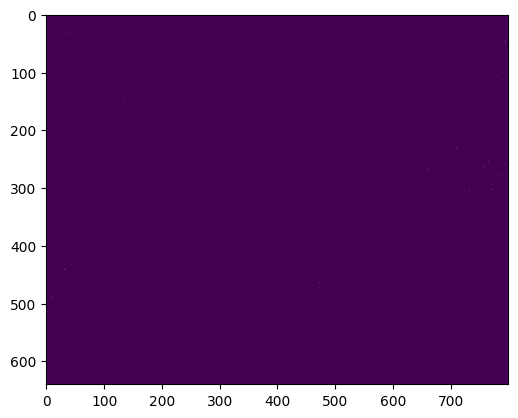

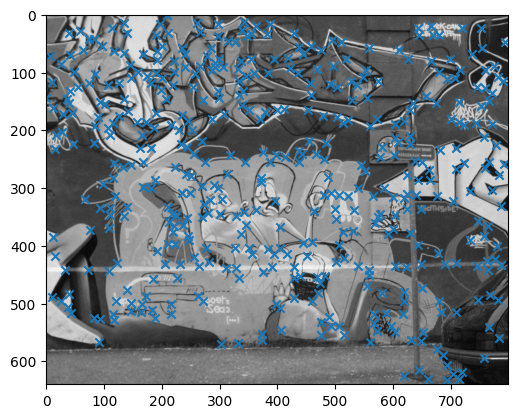

In [29]:

def harris_feature_points(image, sigma, smoothing_sigma, alpha, tresh, neigh_one_side_size):
    x_partial, y_partial = image_partial_derivatives(image, sigma)

    x_partial_squared = x_partial * x_partial
    x_partial_times_y_partial = x_partial * y_partial
    y_partial_squared = y_partial * y_partial

    gauss_1dim = a4u.gauss(smoothing_sigma)
    gauss_2dim = gauss_1dim.T * gauss_1dim
    # print("gauss_2dim")
    # print(gauss_2dim)
    # print("gauss_2dim.sum()")
    # print(gauss_2dim.sum())
    # UZ_utils.imshow(gauss_2dim)

    x_partial_squared_smoothed = a4u.convolve(x_partial_squared, gauss_2dim)
    x_partial_times_y_partial_smoothed = a4u.convolve(x_partial_times_y_partial, gauss_2dim)
    y_partial_squared_smoothed = a4u.convolve(y_partial_squared, gauss_2dim)

    determinant = x_partial_squared_smoothed * y_partial_squared_smoothed - x_partial_times_y_partial_smoothed * x_partial_times_y_partial_smoothed
    trace_squared = (x_partial_squared_smoothed + y_partial_squared_smoothed) * (x_partial_squared_smoothed + y_partial_squared_smoothed)

    combined_result = determinant - alpha * trace_squared




    graf_feature_points = combined_result * (combined_result > tresh)

    graf_feature_points_non_maxima = np.zeros(graf_feature_points.shape)

    for y_ix in range(graf_feature_points.shape[0]):
        for x_ix in range(graf_feature_points.shape[1]):
            y_bot = y_ix - neigh_one_side_size
            y_top = y_ix + neigh_one_side_size
            x_left = x_ix - neigh_one_side_size
            x_right = x_ix + neigh_one_side_size

            if y_bot < 0:
                y_bot = 0
            if y_top > graf_feature_points.shape[0] - 1:
                y_top = graf_feature_points.shape[0] - 1
            
            if x_left < 0:
                x_left = 0
            if x_right > graf_feature_points.shape[1] - 1:
                x_right = graf_feature_points.shape[1] - 1

            neigh_max = graf_feature_points[y_bot:y_top, x_left:x_right].max()
            if graf_feature_points[y_ix, x_ix] == neigh_max:
                graf_feature_points_non_maxima[y_ix, x_ix] = graf_feature_points[y_ix, x_ix]
            

    return graf_feature_points_non_maxima

    



sigma = 3
smoothing_sigma = 1.6 * sigma
t = 1e-6
alpha = 0.06

graf_a = UZ_utils.imread_gray(".\data\graf\graf_a.jpg")
print("graf_a.shape")
print(graf_a.shape)
feature_points = harris_feature_points(graf_a, sigma, smoothing_sigma, alpha,  t, 3)

# print(feature_points)

plt.imshow(feature_points)
plt.show()

feature_point_places = np.nonzero(feature_points)

plt.imshow(graf_a, cmap="gray")
plt.scatter(feature_point_places[1], feature_point_places[0], marker="x")
plt.show()



    

# 2 a

fp_a_best_matches
[ 0  0  6  3  8  7 14 12 14 15 15 16 16 19 18 21 21 23 22 19 21 27 27 28
 27 29 27 29 27 32 31 33 31 34 36 39 35 38 37 40 42 45 43 46 48 44 45 38
 48]
fp_image_ixs_b
(array([  0,   0,   0,   0,   4,   6,   6,   8,   9,  10,  11,  14,  20,
        20,  23,  43,  46,  47,  48,  66,  72,  73,  76,  77,  79,  80,
        83,  96, 100, 148, 154, 166, 166, 168, 190, 215, 220, 227, 234,
       234, 240, 245, 251, 256, 269, 270, 272, 275, 281], dtype=int64), array([ 19,  34, 154, 234, 123, 102, 140, 209,  73, 296,  48, 313,  84,
       328,  29,  92,  24,  43, 101, 215,  30, 287, 129,   9, 189, 298,
       263, 100, 108, 232,   0, 134, 189, 153, 240, 271, 316, 239,  53,
       232, 325, 315, 137, 162, 304, 270, 293, 262, 296], dtype=int64))


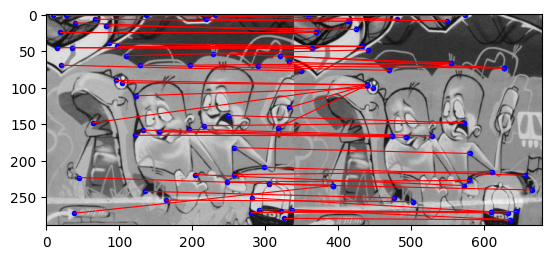

In [30]:
def hellinger_distance(hist1, hist2):
    hist_root_diff = hist1 ** (1/2) - hist2 ** (1/2)
    hist_dist = (1/2 * np.sum(hist_root_diff ** 2)) ** (1/2)
    return hist_dist

def find_correspondances(features_a, features_b):
    """
    features_a is a list of lists.
    Its 0th element is a list of descriptors for the 0th feature point.

    Returns 2 arrays.
    The 0th elem of the first array contains the ix from features_b, that was
    the best corresponding point to the 0th element of features_a.

    The second returning array is vice versa.
    """
    features_a_best_matches = np.zeros(features_a.shape[0])
    features_b_best_matches = np.zeros(features_b.shape[0])

    for a_ix in range(features_a.shape[0]):
        b_ix_current_best = -1
        dist_current_best = float('inf')

        for b_ix in range(features_b.shape[0]):
            dist_current = hellinger_distance(features_a[a_ix], features_b[b_ix])
            if dist_current < dist_current_best:
                dist_current_best = dist_current
                b_ix_current_best = b_ix
        
        features_a_best_matches[a_ix] = b_ix_current_best
    

    for b_ix in range(features_b.shape[0]):
        a_ix_current_best = -1
        dist_current_best = float('inf')

        for a_ix in range(features_a.shape[0]):
            dist_current = hellinger_distance(features_b[b_ix], features_a[a_ix])
            if dist_current < dist_current_best:
                dist_current_best = dist_current
                a_ix_current_best = a_ix
        
        features_b_best_matches[b_ix] = a_ix_current_best

    
    features_a_best_matches = features_a_best_matches.astype('int')
    features_b_best_matches = features_b_best_matches.astype('int')

    return features_a_best_matches, features_b_best_matches






sigma = 3
smoothing_sigma = 1.6 * sigma
t = 1e-5
alpha = 0.06
non_max_neigh = 3

n_bins = 16

graf_a = UZ_utils.imread_gray(".\data\graf\graf_a_small.jpg")
graf_b = UZ_utils.imread_gray(".\data\graf\graf_b_small.jpg")


def harris_simple_desc(image, sigma, smoothing_sigma, alpha,  tresh, non_max_neigh, n_bins):
    fp_image = harris_feature_points(image, sigma, smoothing_sigma, alpha,  tresh, non_max_neigh)
    fp_places_image = np.nonzero(fp_image)
    simple_descs = a4u.simple_descriptors(graf_a, fp_places_image[0], fp_places_image[1], n_bins)
    # print(simple_descriptors)
    return fp_places_image, simple_descs



fp_image_ixs_a, simple_descs_a = harris_simple_desc(graf_a, sigma, smoothing_sigma, alpha,  t, non_max_neigh, n_bins)
fp_image_ixs_b, simple_descs_b = harris_simple_desc(graf_b, sigma, smoothing_sigma, alpha,  t, non_max_neigh, n_bins)

# these are the indexes of the other best matches, They point to their most corresponding point.
fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

print("fp_a_best_matches")
print(fp_a_best_matches)

print("fp_image_ixs_b")
print(fp_image_ixs_b)

# Now we make Nx2 vectors, left column being the x coordinate. The a4u function asks for this.
fp_a_match_image_ixs = np.zeros((fp_a_best_matches.size, 2))
for i in range(fp_a_best_matches.size):
    ix = fp_a_best_matches[i]

    fp_a_match_image_ixs[i, 0] = fp_image_ixs_b[1][ix]
    fp_a_match_image_ixs[i, 1] = fp_image_ixs_b[0][ix]


fp_image_ixs_a_for_display = np.zeros((fp_image_ixs_a[0].size, 2))
for i in range(fp_image_ixs_a[0].size):
    fp_image_ixs_a_for_display[i, 0] = fp_image_ixs_a[1][i]
    fp_image_ixs_a_for_display[i, 1] = fp_image_ixs_a[0][i]


a4u.display_matches(graf_a, fp_image_ixs_a_for_display, graf_b, fp_a_match_image_ixs)






# 2 b

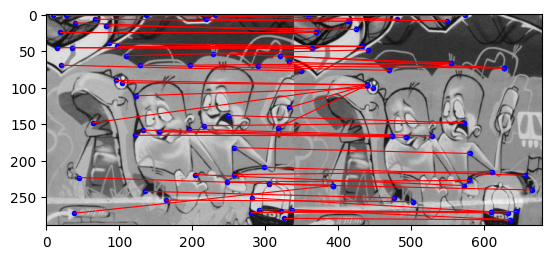

In [33]:

def find_matches(image_a, image_b):
    sigma = 3
    smoothing_sigma = 1.6 * sigma
    t = 1
    alpha = 0.06
    non_max_neigh = 3

    n_bins = 16

    fp_image_ixs_a, simple_descs_a = harris_simple_desc(image_a, sigma, smoothing_sigma, alpha, t, non_max_neigh, n_bins)
    fp_image_ixs_b, simple_descs_b = harris_simple_desc(image_b, sigma, smoothing_sigma, alpha, t, non_max_neigh, n_bins)

    fp_image_ixs_a = list(zip(fp_image_ixs_a[0], fp_image_ixs_a[1]))
    fp_image_ixs_b = list(zip(fp_image_ixs_b[0], fp_image_ixs_b[1]))

    # these are the indexes of the other best matches, They point to their most corresponding point.
    fp_a_best_matches, fp_b_best_matches = find_correspondances(simple_descs_a, simple_descs_b)

    fp_symetric_matches = []

    for a_ix in range(fp_a_best_matches.size):
        matched_b_ix = fp_a_best_matches[a_ix]
        matches_match = fp_b_best_matches[matched_b_ix]

        if a_ix == matches_match:
            fp_symetric_matches.append((fp_image_ixs_a[a_ix], fp_image_ixs_b[matched_b_ix]))

    return fp_symetric_matches





graf_a = UZ_utils.imread_gray(".\data\graf\graf_a_small.jpg")
graf_b = UZ_utils.imread_gray(".\data\graf\graf_b_small.jpg")

matched_pairs_of_ixs = find_matches(graf_a, graf_b)

graf_a_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))
graf_b_array_for_display = np.zeros((len(matched_pairs_of_ixs), 2))

for i in range(len(matched_pairs_of_ixs)):
    graf_a_array_for_display[i, 0] = matched_pairs_of_ixs[i][0][1]
    graf_a_array_for_display[i, 1] = matched_pairs_of_ixs[i][0][0]
    graf_b_array_for_display[i, 0] = matched_pairs_of_ixs[i][1][1]
    graf_b_array_for_display[i, 1] = matched_pairs_of_ixs[i][1][0]


a4u.display_matches(graf_a, fp_image_ixs_a_for_display, graf_b, fp_a_match_image_ixs)


